# Topic2. A* path planning

If you got the point for problem definition in AIMA textbook, please execute and run the block until section 1-4

## 2-1. Import python package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
import numpy as np
from collections import defaultdict, deque, Counter
from itertools import combinations

## 2-2. Problem abstract & State-space tree node & queue

In [2]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    Subclasses can add other keywords besides initial and goal.
    The default heuristic is 0 and the default step cost is 1 for all states."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
    
    
    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def is_goal(self, state):           return state == self.goal
    def step_cost(self, s, action, s1): return 1
    def h(self, node):                  return 0
    
    def __str__(self):
        return '{}({}, {})'.format(type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=float('inf')) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=float('inf')) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.step_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    return [] if node.parent is None else path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): return []
    return path_states(node.parent) + [node.state]

In [3]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

<font color="red">
    
## 2-3. Search methods
</font>

This section declare classic search algorithms to solve the problem defined above. Noted that we made a change in the code. `reached` variable need to be changed to global varible for storing the process of searching.

In [4]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    frontier = FIFOQueue([Node(problem.initial)])
    global reached # <<<<<<<<<<< Only change here
    reached = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure

In [5]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first; make `reached` global."
    global reached # <<<<<<<<<<< Only change here
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while len(frontier) != 0:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if (s not in reached) or (child.path_cost < reached[s].path_cost):
                reached[s] = child
                frontier.add(child)
    return failure

# It is also popular to Dijkstra's algorithm
def uniform_cost_search(problem):
    "Search nodes with minimum  path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + h(node))


def weighted_astar_search(problem, weight=1.4, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + weight * h(node))

def greedy_best_first_search(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

<font color="red">
    
## 2-4. Grid Problem

</font>

We define a `GridProblem` class here to present a problem has an initial point, a goal point, obstacles and other limitations. Assume a robot is locate on initial point, you need to use search method to plan a path and avoid robot bump into the wall.

In [30]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""
    
    def __init__(self, initial=(0.5, 0.5), goal=(1.5, 2.5), obstacles=(),
                 grid_size=0.2, veh_size=(0.2, 0.2), MAP_RANGE=(1.8, 3.0), **kwds):
        
        Problem.__init__(self, initial=initial, goal=goal, obstacles=set(obstacles) - {initial, goal},
                         grid_size=grid_size, veh_size=veh_size, MAP_RANGE=MAP_RANGE, **kwds)
        
        
        if not self.is_state_safe(self.goal):
            raise ValueError('Initial point:{} or goal:{} is out of range {}~{} m'.format( \
                                self.initial, self.goal, self.veh_size, \
                                (self.MAP_RANGE[0]-self.veh_size[0], self.MAP_RANGE[1]-self.veh_size[1])))
        
        self.directions = [(0, -1), (-1, 0), (1,  0), (0, +1)]
        
        self.gridmap = set()
        
        self.to_grid = lambda state: (int(state[0]*10/self.grid_size/10), int(state[1]*10/self.grid_size/10))
        self.generate_gridmap()
    
    def is_state_safe(self, state):
        if state[0] < self.veh_size[0] or state[0] > self.MAP_RANGE[0]-self.veh_size[0] or \
            state[1] < self.veh_size[1] or state[1] > self.MAP_RANGE[1]-self.veh_size[1]:
            return False
        else:    return True
    
    def generate_gridmap(self):
        for p in self.obstacles:
            self.gridmap.add(self.to_grid(p))
            
    def step_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        result_grid_loc = self.to_grid(state)
        return action if action not in self.gridmap else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        grid_p = self.to_grid(state)
        action_list = []
        for (dx, dy) in self.directions:
            next_p = (grid_p[0]+dx, grid_p[1]+dy)
            if next_p not in self.gridmap:
                action_list.append((round(next_p[0]*self.grid_size + 0.5*self.grid_size, 3), \
                                    round(next_p[1]*self.grid_size + 0.5*self.grid_size, 3)))
        return action_list
    
    def is_goal(self, state):
        return self.to_grid(state) == self.to_grid(self.goal)


## 2-5. Obstacle generator

This section is prepared for obstacle generator. Note that we use `yield` to create iterable variable, then use `set()` to include all elements in the grid problem. If you want to know more about `yield`, please ask TA or visit [Stackflew](https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do) or [Chinese intro](https://liam.page/2017/06/30/understanding-yield-in-python/).

In [31]:
def transpose(matrix): return list(zip(*matrix))

# The following can be used to create obstacles:
def straight_line_distance(point1, point2):
    "Straight-line distance between two 2D points."
    return abs(complex(*point1) - complex(*point2))
    

def random_lines(X=np.arange(0, 2, 0.1), Y=np.arange(0, 3, 0.1), N=10, lengths=np.arange(1, 3, 0.1), dirs=((0, 1), (1, 0))):
    """Yield the cells in N random lines of the given lengths."""
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(dirs)
        for obj_line in line(x, y, dx, dy, random.choice(lengths)):
            yield obj_line            
            
def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in np.arange(0, length*1.001, 0.01)}

def add_block(x, y, len_x, len_y):
    for obj_line in line(x, y, 1, 0, len_x):
        yield obj_line
    for obj_line in line(x, y+len_y, 1, 0, len_x):
        yield obj_line
    for obj_line in line(x, y, 0, 1, len_y):
        yield obj_line
    for obj_line in line(x+len_x, y, 0, 1, len_y):
        yield obj_line

def fixed_map(obs_list=None, obs_size=(0.25, 0.25)):
    for obj_line in add_block(x=0, y=0, len_x=1.6, len_y=2.8):
        yield obj_line
    for obj_line in add_block(x=0.7, y=1.3, len_x=0.3, len_y=0.3):
        yield obj_line
    if obs_list != None:
        for obs in obs_list:
            for obj_line in add_block(x=obs[0]-obs_size[0]/2, y=obs[1]-obs_size[1]/2, \
                                          len_x=obs_size[0], len_y=obs_size[1]):
                yield obj_line
        

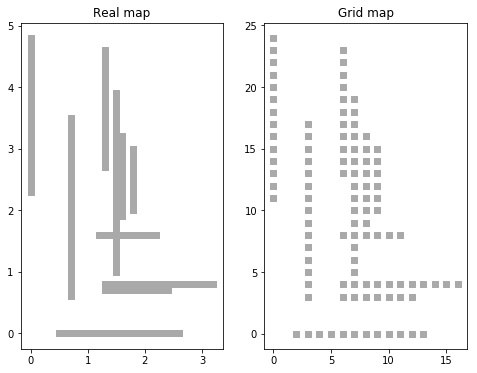

In [32]:
# Difference between real map and grid map
gp1 = GridProblem(grid_size=0.2, obstacles=random_lines())

plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.title('Real map')
obs_list = transpose(list(gp1.obstacles))
plt.scatter(obs_list[0], obs_list[1], marker='s', color='darkgrey')

plt.subplot(122)
plt.title('Grid map')
grid_list = transpose(list(gp1.gridmap))
plt.scatter(grid_list[0], grid_list[1], marker='s', color='darkgrey')
plt.show()

## 2-6. Ploting function

Here we declare a ploting function to visialize problem and test some search algorithm. you can see difference of them.

In [9]:
def plot_grid_problem(grid_problem, solution, reached=(), title='Search'):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    plt.figure(figsize=(15, 6))
    plt.axis('off'); plt.axis('equal')
    
    # plot initial position and goal
    start = grid_problem.to_grid(grid_problem.initial)
    goal = grid_problem.to_grid(grid_problem.goal)
    plt.scatter(start[0], start[1], 11**2, marker='D', c='green')
    plt.scatter(goal[0], goal[1], 10**2, marker='D', c='red')
    plt.legend(['current_loc', 'goal_loc'])
    
    # plot obstacle
    obs_list = transpose(list(grid_problem.gridmap))
    if len(obs_list) != 0:
        plt.scatter(obs_list[0], obs_list[1], marker='s', color='darkgrey')
    
    # plot reached path
    reached_list = transpose([grid_problem.to_grid(point) for point in reached])
    if len(reached_list) != 0:
        plt.scatter(reached_list[0], reached_list[1], 1**2, marker='.', c='blue')
    
    # plot solution path
    traj_list = transpose([grid_problem.to_grid(point) for point in path_states(solution)])
    if len(traj_list) != 0:
        plt.scatter(traj_list[0], traj_list[1], marker='s', c='black')

    plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 40, title, solution.path_cost, len(reached)))

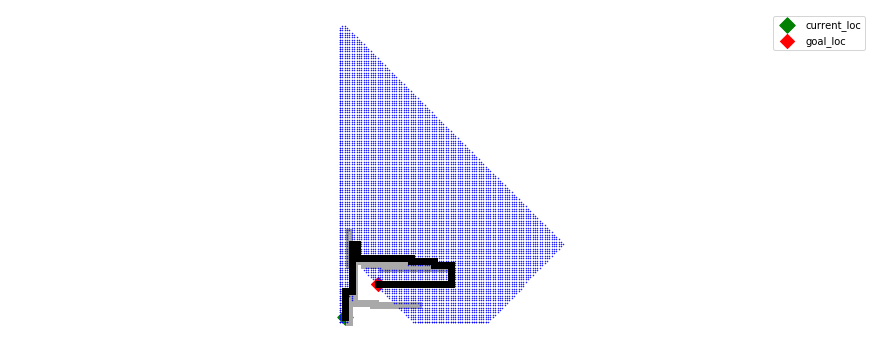

                                         Breadth first search: 12.5 path cost, 6,929 states reached


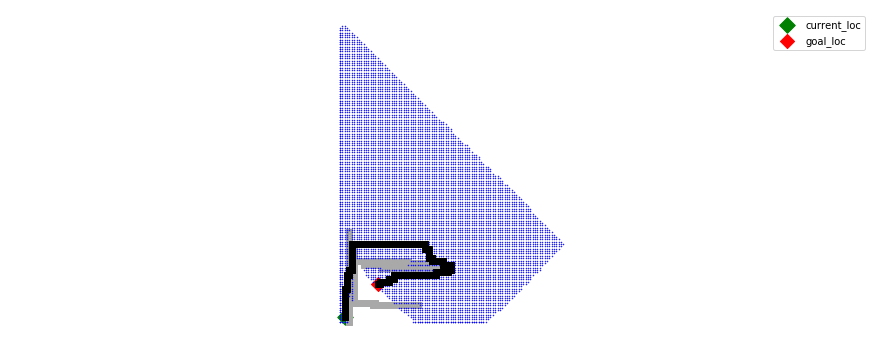

                                         Dijkstra (Uniform cost) search: 12.5 path cost, 6,952 states reached


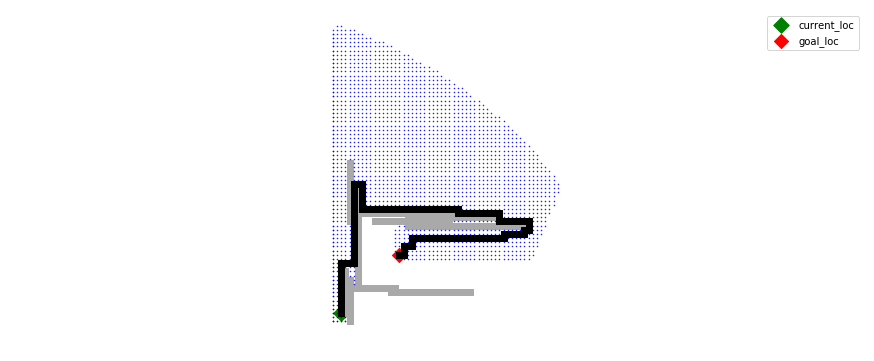

                                         A* search: 12.5 path cost, 2,190 states reached


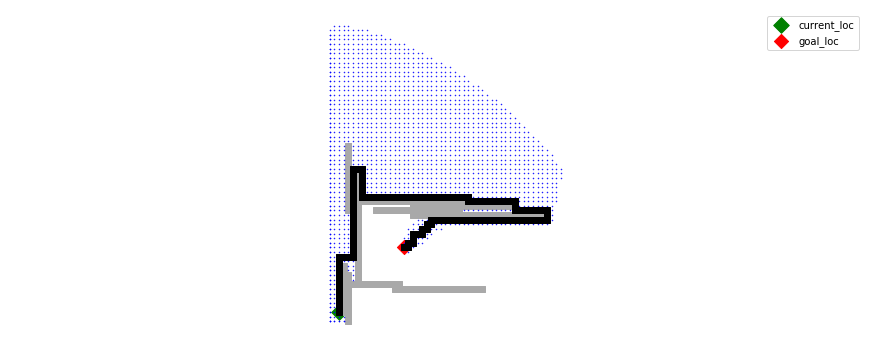

                                         Weighted A* search: 12.5 path cost, 1,690 states reached


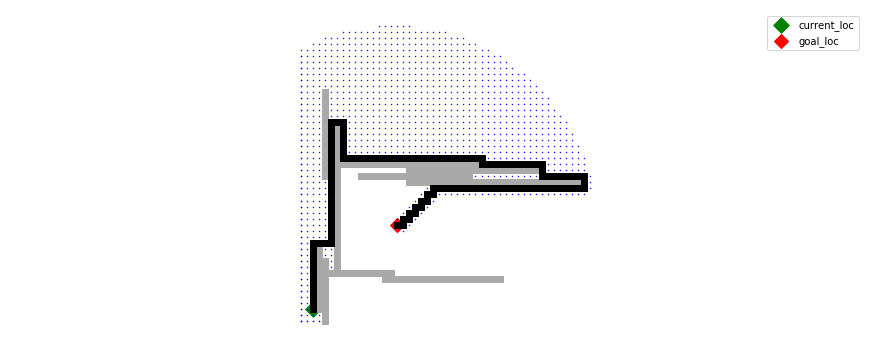

                                         Greedy best first search: 12.5 path cost, 1,149 states reached


In [10]:
# Test algorithms
gp1 = GridProblem(initial=(0.2, 0.2), goal=(1.6, 1.6), grid_size=0.1, obstacles=random_lines(N=10))
sol1 = breadth_first_search(gp1)
plot_grid_problem(gp1, sol1, reached, title='Breadth first')

sol2 = uniform_cost_search(gp1)
plot_grid_problem(gp1, sol2, reached, title='Dijkstra (Uniform cost)')

sol3 = astar_search(gp1)
plot_grid_problem(gp1, sol3, reached, title='A*')

sol4 = weighted_astar_search(gp1)
plot_grid_problem(gp1, sol4, reached, title='Weighted A*')

sol5 = greedy_best_first_search(gp1)
plot_grid_problem(gp1, sol5, reached, title='Greedy best first')

<font color="red">
    
# ROS start here
</font>

### Import ROS related package

In [11]:
import os
sys.path.insert(0, '/opt/ros/kinetic/lib/python2.7/dist-packages')
sys.path.insert(0, 'catkin_ws/devel/lib/python2.7/dist-packages')
os.environ["ROS_MASTER_URI"] = "http://192.168.50.19:11311"

import rospy
import tf

# Create path msh to mmbot
from nav_msgs.msg import Odometry, Path
from geometry_msgs.msg import PoseStamped

# Location msg from watch tower server
from duckietown_msgs.msg import Pose2DStamped, GlobalPoseArray

## ROS node initialization

In [12]:
rospy.init_node("path_planning_node", anonymous = False)
path_pub = rospy.Publisher('/planning_path', Path, queue_size=10)

### This section will demostrate how to get the location msg and publish the planning path to the robot

In [26]:
initial_point = (0, 0)
obs_list = [(0, 0), (0, 0)]
while initial_point == (0, 0) or obs_list[0] == (0, 0):
    msg = rospy.wait_for_message("/nctuece/pose_optimization/bot_global_poses_optimized", \
                                         topic_type=GlobalPoseArray, \
                                         timeout=10)
#     print(len( msg.poses))
    for pose in msg.poses:
        if pose.bot_id == 432: obs_list[0] = pose.pose.x, pose.pose.y
        if pose.bot_id == 433: obs_list[1] = pose.pose.x, pose.pose.y
        if pose.bot_id == 426: # id=427--> mmbot14, id=426--> mmbot16
            initial_point = (pose.pose.x, pose.pose.y)
            break
        

print('Initial_point: {}'.format(initial_point))
print('Obstacle list: {}'.format(obs_list))

Initial_point: (0.5286002245699926, 2.556273506258781)
Obstacle list: [(0.7391016352610082, 1.138060017811456), (0, 0)]


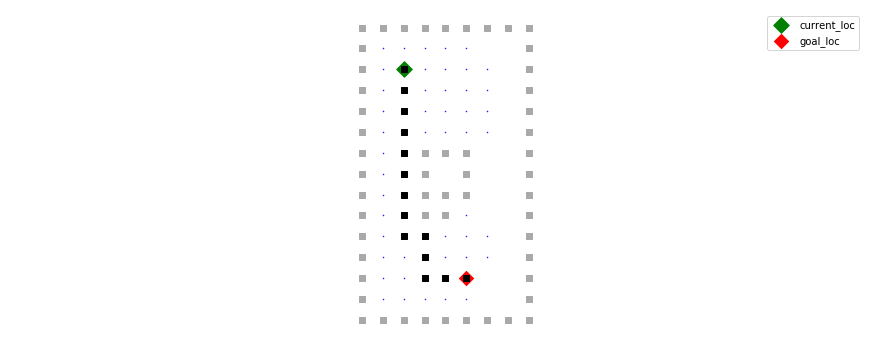

                                         Search search: 2.7 path cost, 60 states reached


In [27]:
gp1 = GridProblem(initial=initial_point, goal=(1., 0.4), grid_size=0.2, obstacles=fixed_map(obs_list=obs_list))
solution = astar_search(gp1)
plot_grid_problem(gp1, solution, reached)

In [15]:
path = Path()
path.header.frame_id = 'map'
path.header.stamp = rospy.Time.now()

traj_list = list(path_states(solution))

print('planning trajectory:')
for a in traj_list: print(a)
    
for i in range(len(traj_list)-1) :
    p = PoseStamped()
    p.header.frame_id = 'map'
    p.header.stamp = rospy.Time.now()
    p.pose.position.x = traj_list[i][0]
    p.pose.position.y = traj_list[i][1]
    
    head_angle = math.atan2(traj_list[i+1][1] - traj_list[i][1],
                            traj_list[i+1][0] - traj_list[i][0])
#     print(p.pose.position.x, p.pose.position.y, head_angle*180.0/math.pi)
    
    (p.pose.orientation.x, p.pose.orientation.y, p.pose.orientation.z, p.pose.orientation.w) = tf.transformations.quaternion_from_euler(0, 0, math.pi)
    path.poses = path.poses + [p]

# publish path msg
# for i in range(10):
#     path_pub.publish(path)

planning trajectory:
(0.5296115879464331, 2.4232251420141457)
(0.5, 2.3)
(0.5, 2.1)
(0.5, 1.9)
(0.5, 1.7)
(0.5, 1.5)
(0.5, 1.3)
(0.5, 1.1)
(0.7, 1.1)
(0.7, 0.9)
(0.7, 0.7)
(0.7, 0.5)
(0.9, 0.5)
(1.1, 0.5)


1
1
2
Initial_point: (0.529886192387971, 2.5573061695039745)


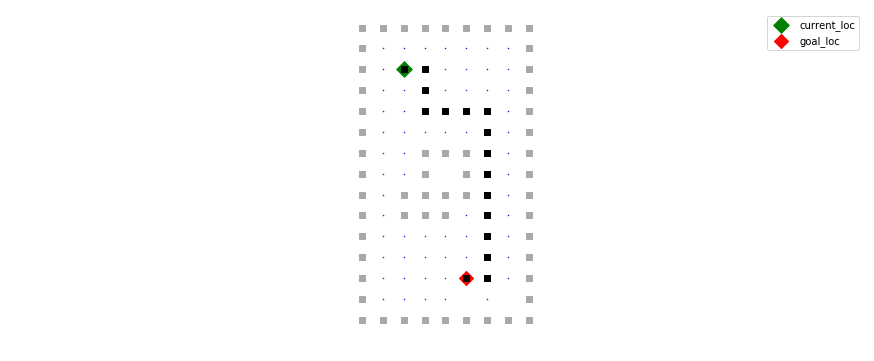

                                         Search search: 3.0 path cost, 76 states reached
(0.529886192387971, 2.5573061695039745)
[(0.529886192387971, 2.5573061695039745), (0.7, 2.5), (0.7, 2.3), (0.7, 2.1), (0.9, 2.1), (1.1, 2.1), (1.3, 2.1), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.3, 0.9), (1.3, 0.7), (1.3, 0.5), (1.1, 0.5)]
1
2
Initial_point: (0.5296143390152404, 2.5570488787379912)


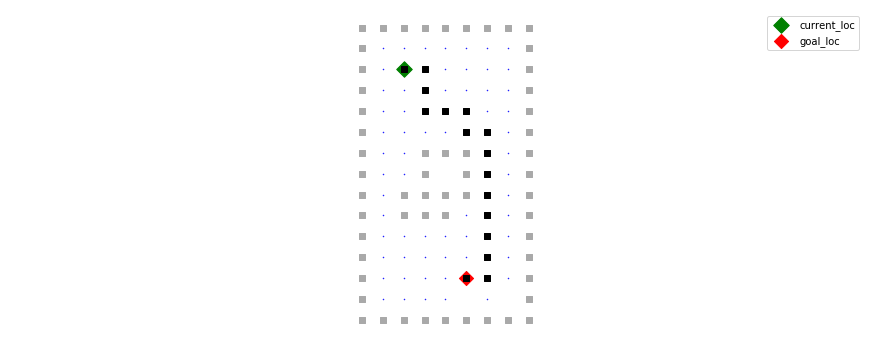

                                         Search search: 3.0 path cost, 76 states reached
(0.5296143390152404, 2.5570488787379912)
[(0.5296143390152404, 2.5570488787379912), (0.7, 2.5), (0.7, 2.3), (0.7, 2.1), (0.9, 2.1), (1.1, 2.1), (1.1, 1.9), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.3, 0.9), (1.3, 0.7), (1.3, 0.5), (1.1, 0.5)]
2
1
Initial_point: (0.5269843427353935, 2.4056722121575667)


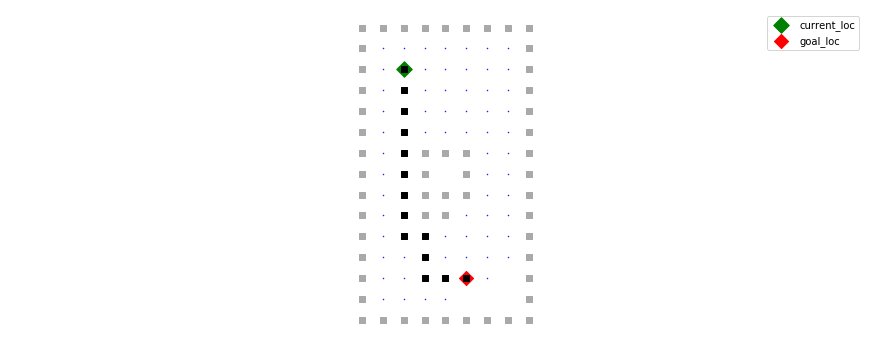

                                         Search search: 2.5 path cost, 76 states reached
(0.5269843427353935, 2.4056722121575667)
[(0.5269843427353935, 2.4056722121575667), (0.5, 2.3), (0.5, 2.1), (0.5, 1.9), (0.5, 1.7), (0.5, 1.5), (0.5, 1.3), (0.5, 1.1), (0.5, 0.9), (0.7, 0.9), (0.7, 0.7), (0.7, 0.5), (0.9, 0.5), (1.1, 0.5)]
2
1
Initial_point: (0.6159531529554811, 2.2288737534479717)


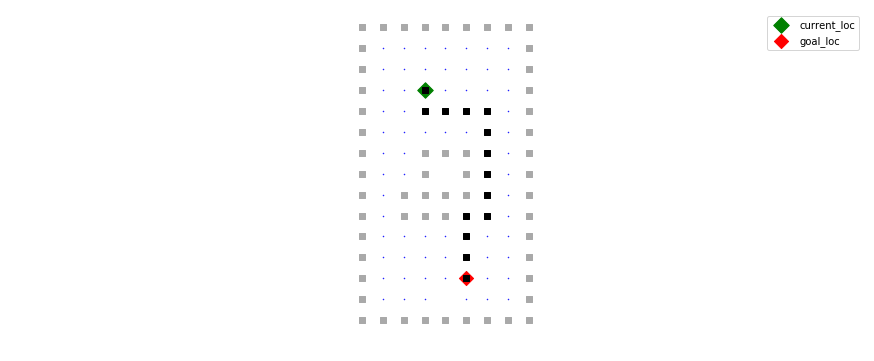

                                         Search search: 2.6 path cost, 77 states reached
(0.6159531529554811, 2.2288737534479717)
[(0.6159531529554811, 2.2288737534479717), (0.7, 2.1), (0.9, 2.1), (1.1, 2.1), (1.3, 2.1), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.1, 1.1), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
1
2
Initial_point: (0.5996855140208934, 2.139222397681909)


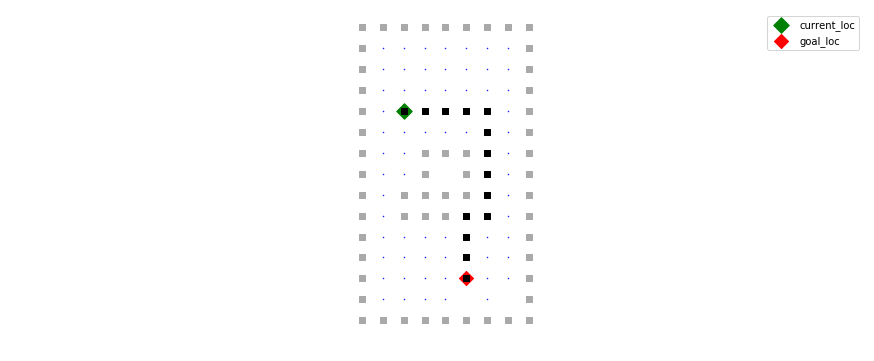

                                         Search search: 2.5 path cost, 76 states reached
(0.5996855140208934, 2.139222397681909)
[(0.5996855140208934, 2.139222397681909), (0.7, 2.1), (0.9, 2.1), (1.1, 2.1), (1.3, 2.1), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.1, 1.1), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
2
1
Initial_point: (0.6557980231595185, 1.9445369217119446)


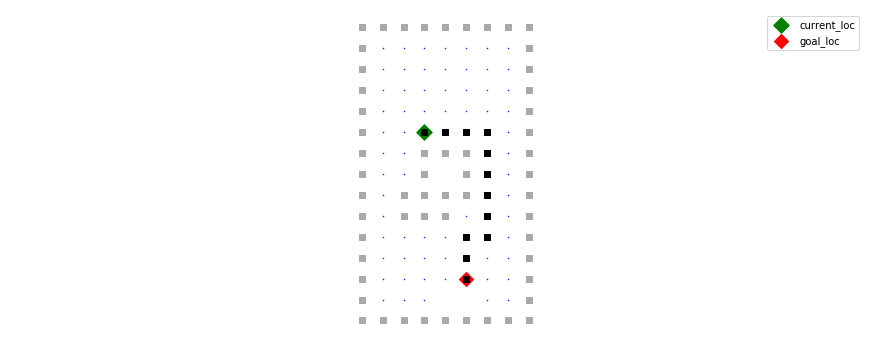

                                         Search search: 2.2 path cost, 76 states reached
(0.6557980231595185, 1.9445369217119446)
[(0.6557980231595185, 1.9445369217119446), (0.9, 1.9), (1.1, 1.9), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
1
2
Initial_point: (0.7141850702573769, 1.9021738036779199)


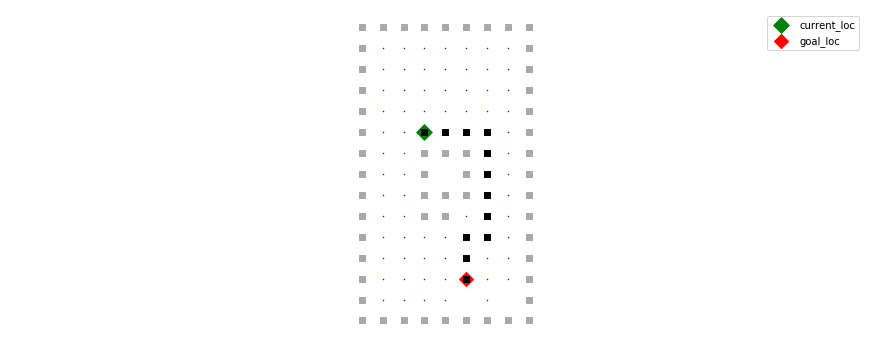

                                         Search search: 2.2 path cost, 78 states reached
(0.7141850702573769, 1.9021738036779199)
[(0.7141850702573769, 1.9021738036779199), (0.9, 1.9), (1.1, 1.9), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
1
2
Initial_point: (0.7828078325815294, 1.8892630164762219)


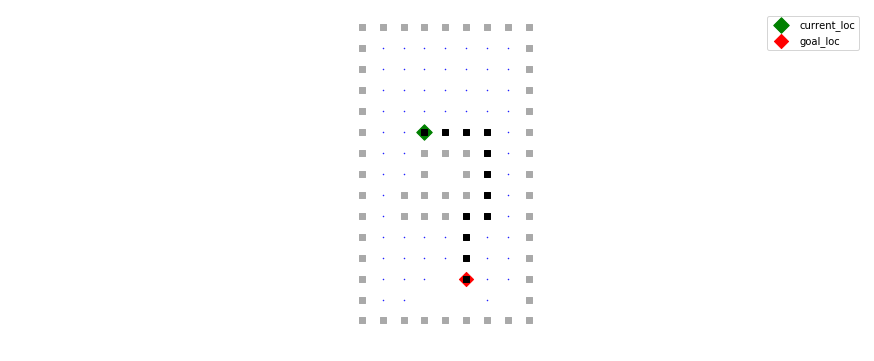

                                         Search search: 2.1 path cost, 73 states reached
(0.7828078325815294, 1.8892630164762219)
[(0.7828078325815294, 1.8892630164762219), (0.9, 1.9), (1.1, 1.9), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.1, 1.1), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
2
2
2
2
1
Initial_point: (0.915658193444998, 1.9051154307846734)


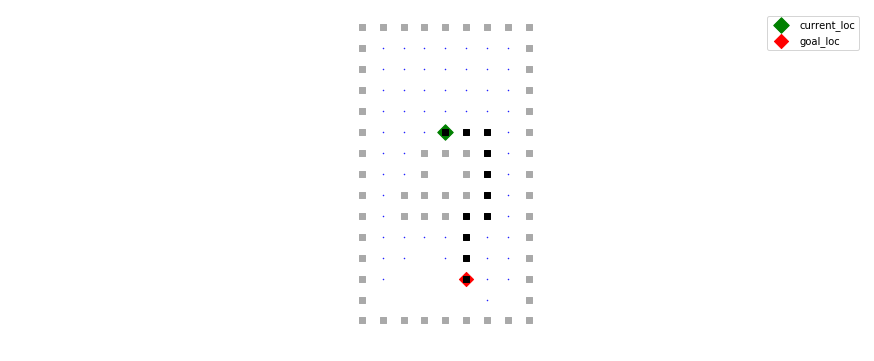

                                         Search search: 2.0 path cost, 68 states reached
(0.915658193444998, 1.9051154307846734)
[(0.915658193444998, 1.9051154307846734), (1.1, 1.9), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.1, 1.1), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
1
2
Initial_point: (0.9665648866398526, 1.9225584913745202)


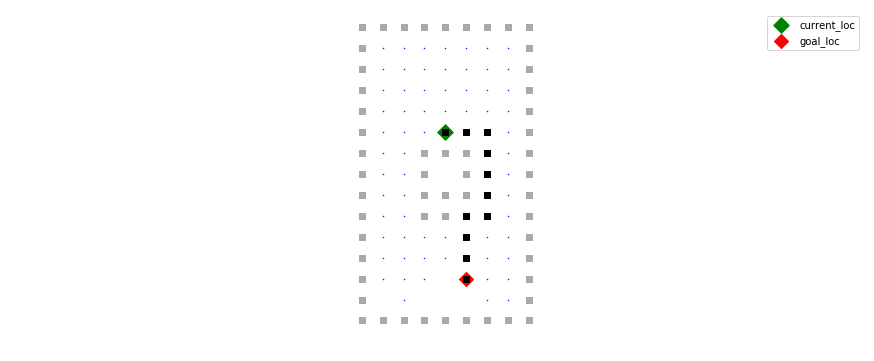

                                         Search search: 1.9 path cost, 75 states reached
(0.9665648866398526, 1.9225584913745202)
[(0.9665648866398526, 1.9225584913745202), (1.1, 1.9), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.1, 1.1), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
1
Initial_point: (1.0428291230669322, 1.9774223380116422)


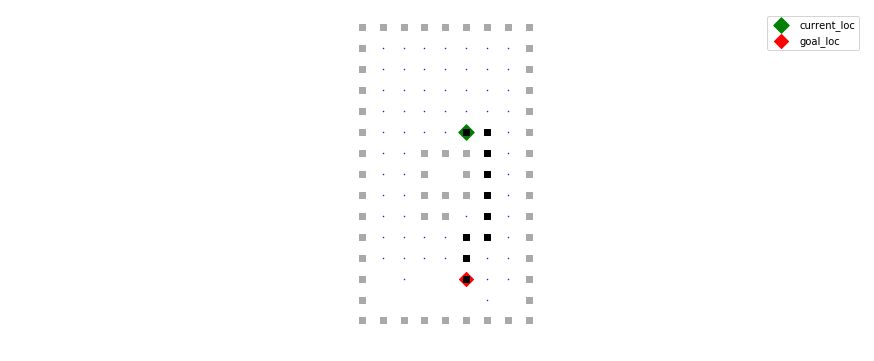

                                         Search search: 1.9 path cost, 71 states reached
(1.0428291230669322, 1.9774223380116422)
[(1.0428291230669322, 1.9774223380116422), (1.3, 1.9), (1.3, 1.7), (1.3, 1.5), (1.3, 1.3), (1.3, 1.1), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
1
1
2
Initial_point: (1.1156936274528884, 1.9978567461269916)


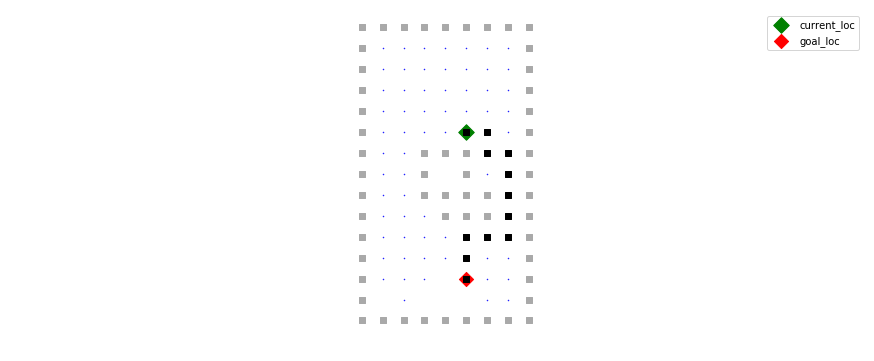

                                         Search search: 2.2 path cost, 73 states reached
(1.1156936274528884, 1.9978567461269916)
[(1.1156936274528884, 1.9978567461269916), (1.3, 1.9), (1.3, 1.7), (1.5, 1.7), (1.5, 1.5), (1.5, 1.3), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
1
3
1
2
Initial_point: (1.2180382982709075, 2.0046786055121713)


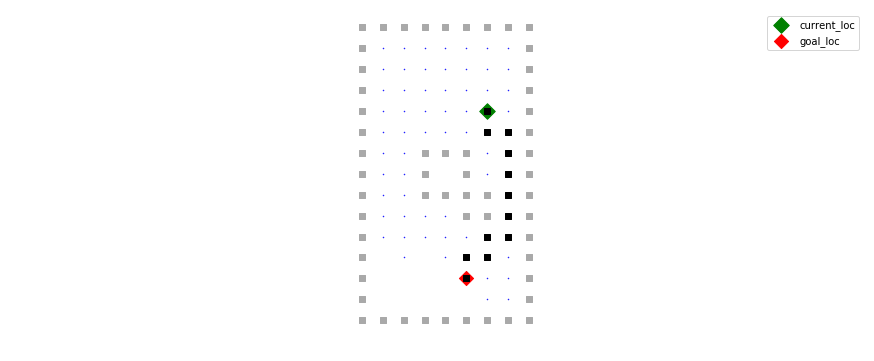

                                         Search search: 2.1 path cost, 68 states reached
(1.2180382982709075, 2.0046786055121713)
[(1.2180382982709075, 2.0046786055121713), (1.3, 1.9), (1.5, 1.9), (1.5, 1.7), (1.5, 1.5), (1.5, 1.3), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.3, 0.7), (1.1, 0.7), (1.1, 0.5)]
2
3
Initial_point: (1.3297998611724586, 1.989181352647121)


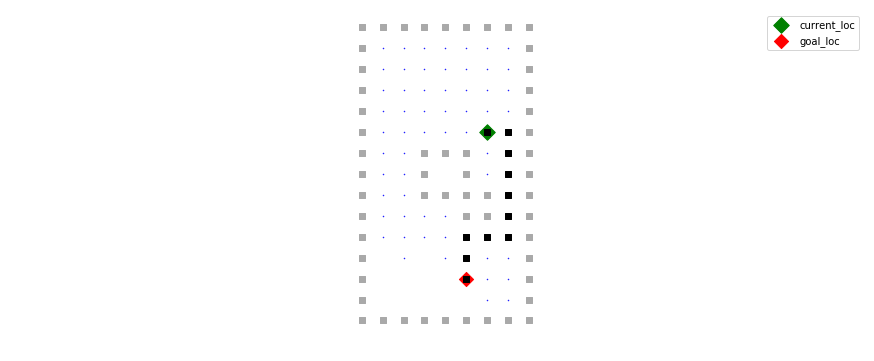

                                         Search search: 2.0 path cost, 68 states reached
(1.3297998611724586, 1.989181352647121)
[(1.3297998611724586, 1.989181352647121), (1.5, 1.9), (1.5, 1.7), (1.5, 1.5), (1.5, 1.3), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
1
1
2
Initial_point: (1.470623759107342, 1.7097020331636)


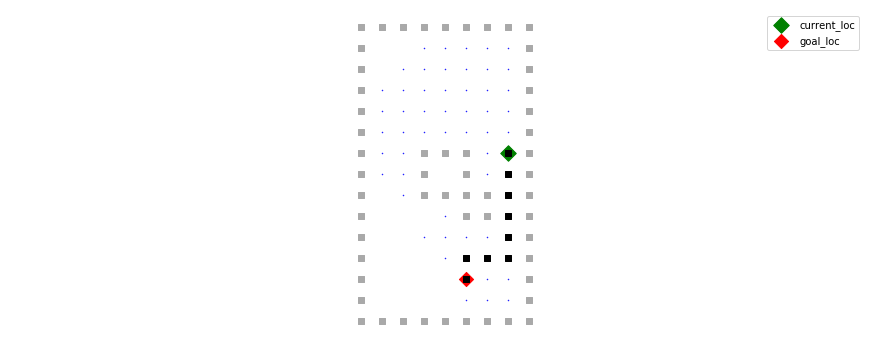

                                         Search search: 1.6 path cost, 59 states reached
(1.470623759107342, 1.7097020331636)
[(1.470623759107342, 1.7097020331636), (1.5, 1.5), (1.5, 1.3), (1.5, 1.1), (1.5, 0.9), (1.5, 0.7), (1.3, 0.7), (1.1, 0.7), (1.1, 0.5)]
2
3
Initial_point: (1.4714489192345452, 1.5977836251931965)


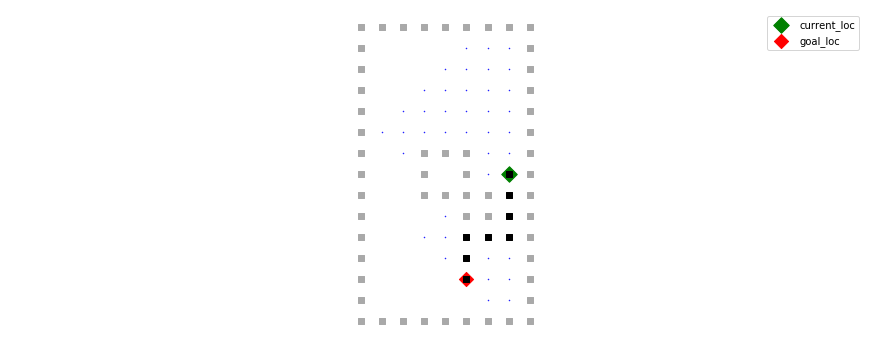

                                         Search search: 1.5 path cost, 47 states reached
(1.4714489192345452, 1.5977836251931965)
[(1.4714489192345452, 1.5977836251931965), (1.5, 1.3), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
2
2
2
2
2
3
Initial_point: (1.4732317118511002, 1.5002248261986626)


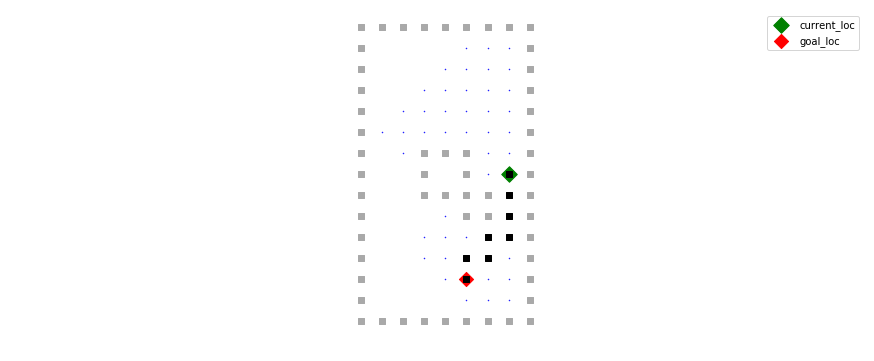

                                         Search search: 1.4 path cost, 50 states reached
(1.4732317118511002, 1.5002248261986626)
[(1.4732317118511002, 1.5002248261986626), (1.5, 1.3), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.3, 0.7), (1.1, 0.7), (1.1, 0.5)]
2
3
Initial_point: (1.4766791347364723, 1.4462260839743344)


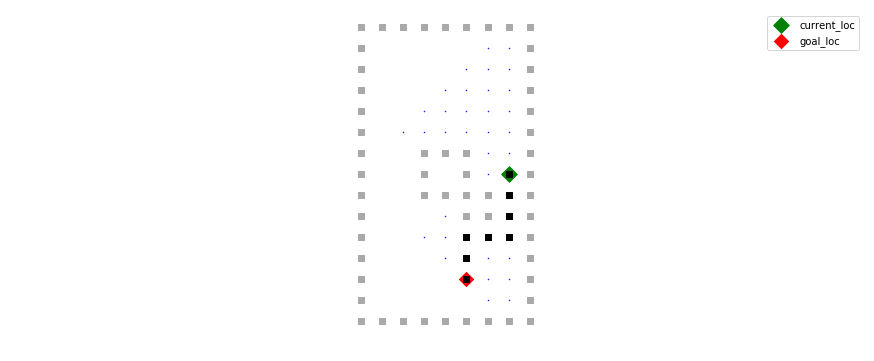

                                         Search search: 1.3 path cost, 41 states reached
(1.4766791347364723, 1.4462260839743344)
[(1.4766791347364723, 1.4462260839743344), (1.5, 1.3), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
3
Initial_point: (1.472301553398688, 1.4133326060126472)


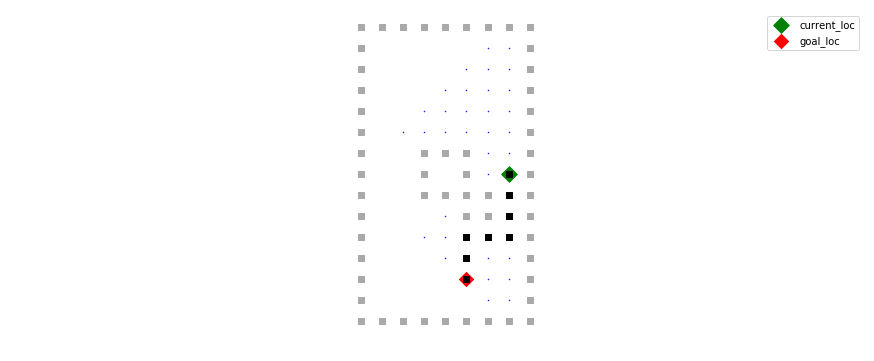

                                         Search search: 1.3 path cost, 41 states reached
(1.472301553398688, 1.4133326060126472)
[(1.472301553398688, 1.4133326060126472), (1.5, 1.3), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
1
Initial_point: (1.484063541216539, 1.318221691700163)


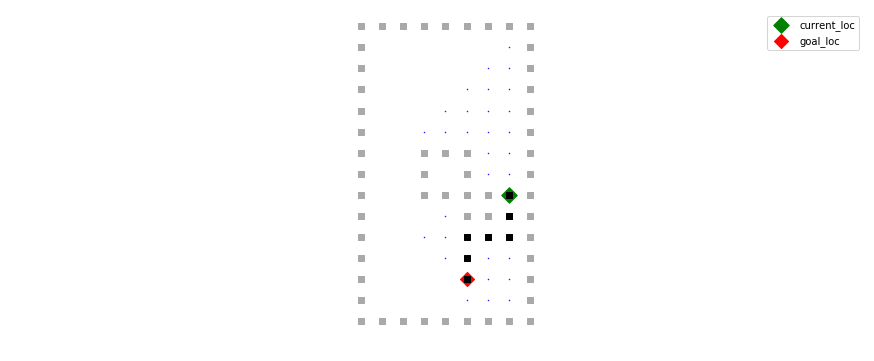

                                         Search search: 1.2 path cost, 37 states reached
(1.484063541216539, 1.318221691700163)
[(1.484063541216539, 1.318221691700163), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
1
2
Initial_point: (1.48557612496296, 1.2702860700976175)


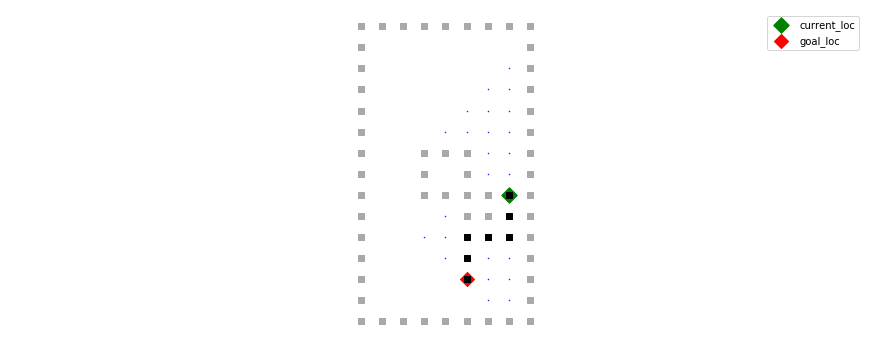

                                         Search search: 1.2 path cost, 31 states reached
(1.48557612496296, 1.2702860700976175)
[(1.48557612496296, 1.2702860700976175), (1.5, 1.1), (1.5, 0.9), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
2
2
1
Initial_point: (1.5012915357423535, 1.0140036341774046)


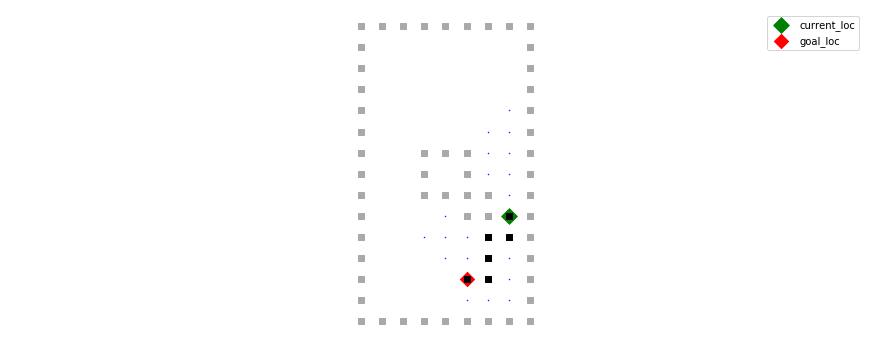

                                         Search search: 0.9 path cost, 25 states reached
(1.5012915357423535, 1.0140036341774046)
[(1.5012915357423535, 1.0140036341774046), (1.5, 0.9), (1.3, 0.9), (1.3, 0.7), (1.3, 0.5), (1.1, 0.5)]
1
2
Initial_point: (1.5118740666852466, 0.9548823284501341)


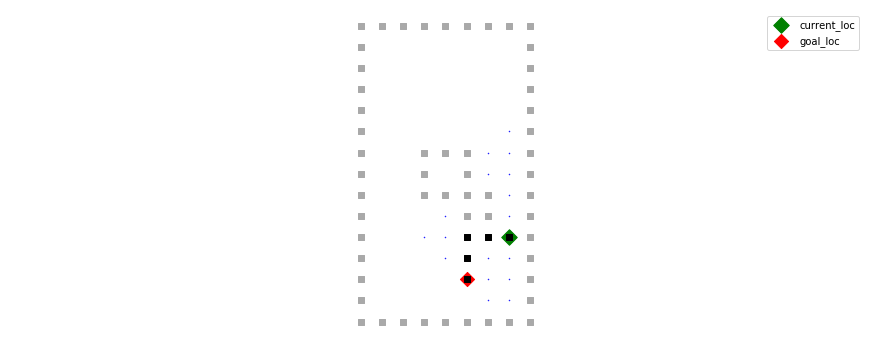

                                         Search search: 0.8 path cost, 22 states reached
(1.5118740666852466, 0.9548823284501341)
[(1.5118740666852466, 0.9548823284501341), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
2
3
Initial_point: (1.4958821568827698, 0.8767206286790873)


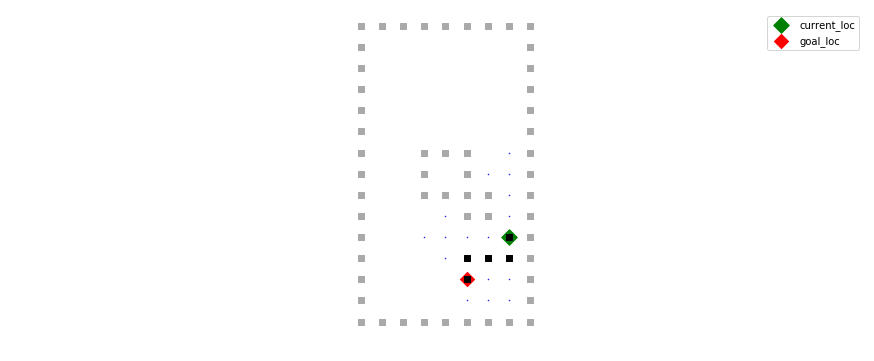

                                         Search search: 0.8 path cost, 21 states reached
(1.4958821568827698, 0.8767206286790873)
[(1.4958821568827698, 0.8767206286790873), (1.5, 0.7), (1.3, 0.7), (1.1, 0.7), (1.1, 0.5)]
2
3
Initial_point: (1.460604531414186, 0.8378534734690025)


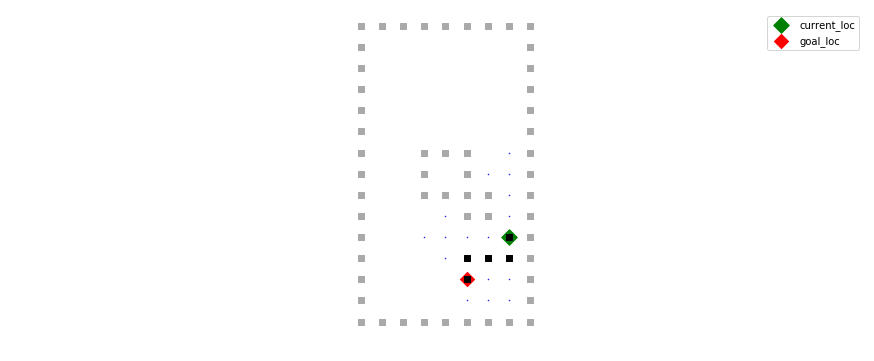

                                         Search search: 0.7 path cost, 21 states reached
(1.460604531414186, 0.8378534734690025)
[(1.460604531414186, 0.8378534734690025), (1.5, 0.7), (1.3, 0.7), (1.1, 0.7), (1.1, 0.5)]
2
3
Initial_point: (1.4013727769797575, 0.8224315687240241)


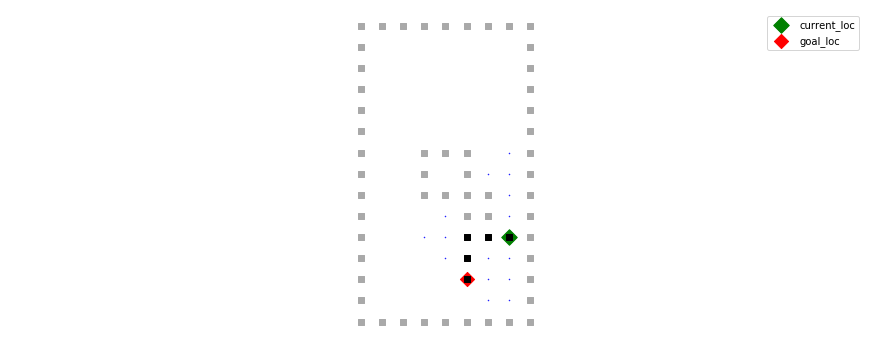

                                         Search search: 0.7 path cost, 20 states reached
(1.4013727769797575, 0.8224315687240241)
[(1.4013727769797575, 0.8224315687240241), (1.3, 0.9), (1.1, 0.9), (1.1, 0.7), (1.1, 0.5)]
2
3
Initial_point: (1.3686240008472588, 0.8114925486766413)


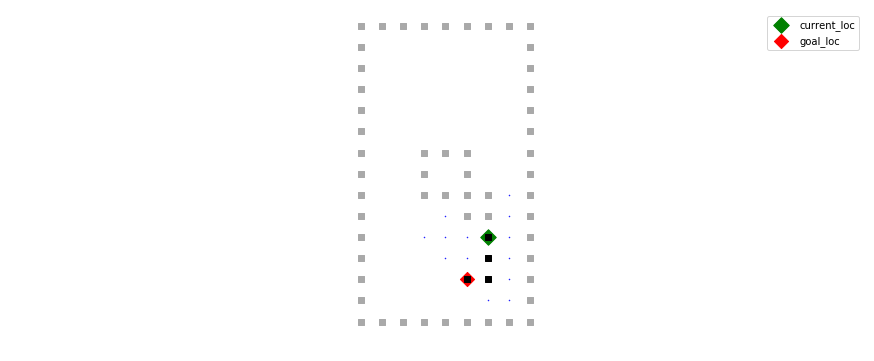

                                         Search search: 0.5 path cost, 17 states reached
(1.3686240008472588, 0.8114925486766413)
[(1.3686240008472588, 0.8114925486766413), (1.3, 0.7), (1.3, 0.5), (1.1, 0.5)]
2
3
Initial_point: (1.3248778306283233, 0.7775565211034129)


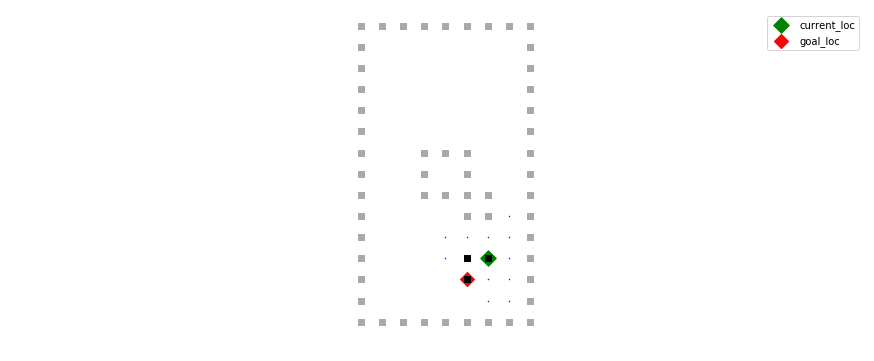

                                         Search search: 0.4 path cost, 14 states reached
(1.3248778306283233, 0.7775565211034129)
[(1.3248778306283233, 0.7775565211034129), (1.1, 0.7), (1.1, 0.5)]
3
2
Initial_point: (1.2646602200025492, 0.7842923700808052)


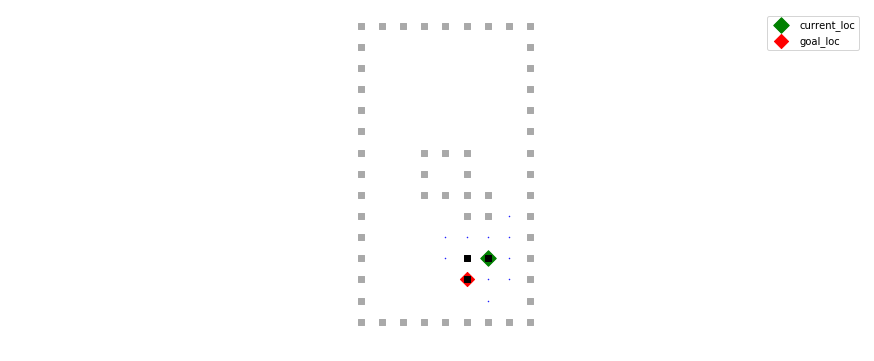

                                         Search search: 0.4 path cost, 13 states reached
(1.2646602200025492, 0.7842923700808052)
[(1.2646602200025492, 0.7842923700808052), (1.1, 0.7), (1.1, 0.5)]
3
3
3
3
2
Initial_point: (1.0309617300442668, 0.6740083528522183)


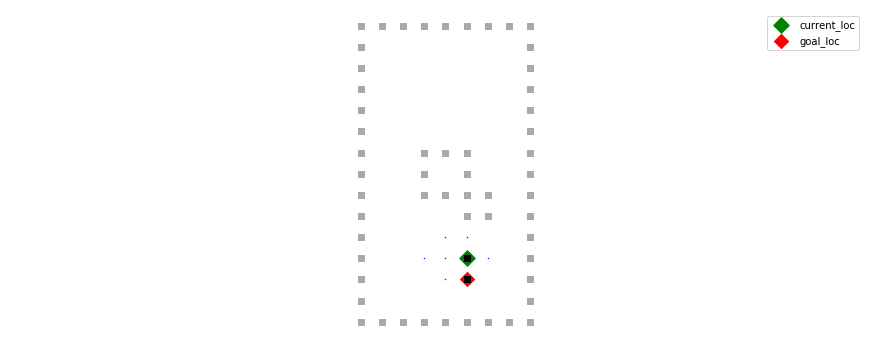

                                         Search search: 0.2 path cost, 8 states reached
(1.0309617300442668, 0.6740083528522183)
[(1.0309617300442668, 0.6740083528522183), (1.1, 0.5)]
1
2
Initial_point: (1.0129310089515728, 0.6296029571403263)


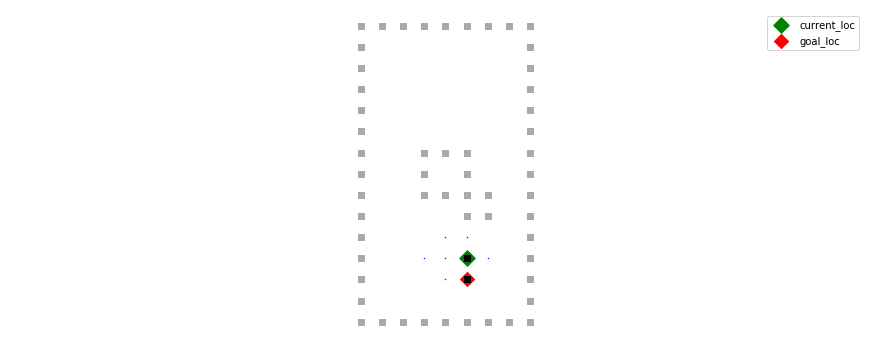

                                         Search search: 0.2 path cost, 8 states reached
(1.0129310089515728, 0.6296029571403263)
[(1.0129310089515728, 0.6296029571403263), (1.1, 0.5)]
2
3
Initial_point: (1.0082843222303606, 0.5659582240595749)


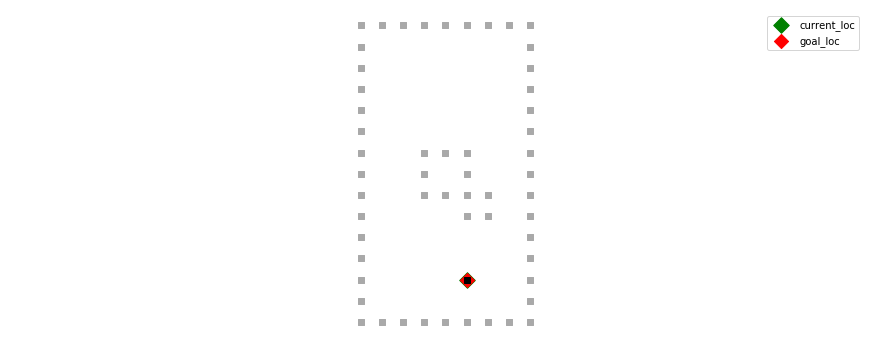

                                         Search search: 0.0 path cost, 0 states reached


[WARN] [1552896761.269644]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


In [29]:
for i in range(50):
    
    initial_point = (0, 0)
    obs_list = [(0, 0), (0, 0)]
    while initial_point == (0, 0) or obs_list[0] == (0, 0):
        msg = rospy.wait_for_message("/nctuece/pose_optimization/bot_global_poses_optimized", \
                                         topic_type=GlobalPoseArray, \
                                         timeout=10)
        print(len( msg.poses))
        for pose in msg.poses:
            if pose.bot_id == 432: obs_list[0] = pose.pose.x, pose.pose.y
            if pose.bot_id == 433: obs_list[1] = pose.pose.x, pose.pose.y
            if pose.bot_id == 426: # id=427--> mmbot14, id=426--> mmbot16
                initial_point = (pose.pose.x, pose.pose.y)
                break

    print('Initial_point: {}'.format(initial_point))
    gp = GridProblem(initial=initial_point, goal=(1, 0.4), grid_size=0.2, obstacles=fixed_map(obs_list=obs_list))
    solution = uniform_cost_search(gp)
    plot_grid_problem(gp, solution, reached)
    
    # Arrived goal
    if gp.to_grid(gp.initial) == gp.to_grid(gp.goal): break
        
    
    # Create path
    path = Path()
    path.header.frame_id = 'map'""
    path.header.stamp = rospy.Time.now()
    traj_list = [p for p in list(path_states(solution))]
    
    print('=====================')
    print(initial_point)
    print(traj_list)
    
    for i in range(len(traj_list)) :
        p = PoseStamped()
        p.header.frame_id = 'map'
        p.header.stamp = rospy.Time.now()
        p.pose.position.x = traj_list[i][0]
        p.pose.position.y = traj_list[i][1]

        if i is len(traj_list)-1:
            p.pose.orientation = path.poses[-1].pose.orientation
        else: 
            head_angle = math.atan2(traj_list[i+1][1] - traj_list[i][1],
                                    traj_list[i+1][0] - traj_list[i][0])
        
        (p.pose.orientation.x, p.pose.orientation.y, p.pose.orientation.z, p.pose.orientation.w) = tf.transformations.quaternion_from_euler(0, 0, math.pi)
        path.poses = path.poses + [p]
    
    for i in range(5):
        path_pub.publish(path)
        
    rospy.sleep(duration=1)